### Notebook to run and test RAG with chat history (v2)

to do:
````
() improve input query / websearch functionality 
    (divide query into subqueries, make webcall for each subquery, 
     make subquery response, stitch responses together as external content to answer
     main query)
     e.g. Is dog A or dog B more active -> Is dog A an active dog? -> A_a/ Is dog B an active dog? A_b
          append A_a + A_b to primary prompt...

 

````

### Step 1: Initialize notebook

In [ ]:
from typing import Annotated, Sequence, Any, List, Dict, Union
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, SystemMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI 
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
import requests
from IPython.display import Image
import trafilatura
from langchain.utilities import GoogleSerperAPIWrapper

### Initialize RAG

In [47]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [48]:
def search_tool(query: Any) -> dict:
    """
    Udfør et web-søgning med Google Serper og hent indholdet fra den mest relevante hjemmeside.
    
    Trin:
      1. Kald GoogleSerperAPIWrapper.results(query) med de danske sprogparametre (hl="da", gl="dk").
      2. Vælg det første (mest relevante) resultat fra de organiske resultater, men undgå eksempelvis ordbogsresultater.
      3. Hent siden med requests og udtræk hovedindholdet med trafilatura.
      4. Returnér et dictionary med:
            - "query": den originale søgeforespørgsel,
            - "search_content": det udtrukne indhold,
            - "source": metadata (URL, titel og snippet).
    """
    # If query is a dict, extract the string.
    if isinstance(query, dict):
        query = query.get("query", "")
    
    search_api = GoogleSerperAPIWrapper(hl="da", gl="dk")
    results = search_api.results(query)
    organic_results = results.get("organic", [])
    
    # Skip results from known dictionary sites.
    valid_result = None
    for result in organic_results:
        url = result.get("link", "").lower()
        if "ordbog" not in url:
            valid_result = result
            break

    if not valid_result:
        return {
            "query": query,
            "search_content": "No results found.",
            "source": None
        }
    
    url = valid_result.get("link", "")
    try:
        response = requests.get(url, timeout=10)
        html = response.text
    except Exception:
        html = ""
    
    content = trafilatura.extract(html)
    if not content or content.strip() == "":
        content = "No content could be extracted from the page."
    
    return {
        "query": query,
        "search_content": content,
        "source": {
            "url": url,
            "title": valid_result.get("title", "No Title"),
            "snippet": valid_result.get("snippet", "No snippet")
        }
    }

In [ ]:
def extract_external_content(messages: Sequence[BaseMessage]) -> str:
    """
    Scan the conversation for any ToolMessage that contains external content.
    Returns the first valid external content found, or an empty string otherwise.
    """
    for msg in messages:
        if isinstance(msg, ToolMessage):
            try:
                # Assuming msg.content is a stringified dict; in production use json.loads.
                result_dict = eval(msg.content)
                ext = result_dict.get("search_content", "")
            except Exception:
                ext = msg.content
            if ext and ext != "No results found.":
                return ext
    return ""

In [ ]:
def build_prompt(query: str, external_content: str = "") -> str:
    base_template = (
        "Du er en ekspert i alt omkring hunde, såsom racer, trivsel og adfærd. "
        "Du skal besvare følgende spørgsmål:\n"
        "----\n"
        "{query}\n"
        "----\n"
        "Dit svar skal være kort og præcist. Du skal være velformuleret, men benytte et flydende og 'casual' sprog. "
        "Du skal ikke svare på andet end du bliver spurgt om."
    )
    if external_content:
        external_template = (
            "Ekstern information hentet fra internettet:\n"
            "{external}\n\n"
        )
        prompt = external_template.format(external=external_content) + base_template.format(query=query)
    else:
        prompt = base_template.format(query=query)
    return prompt

In [ ]:
def build_final_conversation(messages: Sequence[BaseMessage], external_content: str) -> List[BaseMessage]:
    """
    If external content is available, prepend a system message with the external info.
    Otherwise, return the original conversation.
    """
    if external_content:
        system_prompt = (
            "Ekstern information hentet fra internettet:\n"
            f"{external_content}\n\n"
            "Brug denne information til at besvare brugerens spørgsmål."
        )
        sys_msg = SystemMessage(content=system_prompt)
        # Only prepend if a SystemMessage is not already at the beginning.
        if not messages or not isinstance(messages[0], SystemMessage):
            return [sys_msg] + list(messages)
    return list(messages)

In [ ]:
def agent(state: AgentState) -> AgentState:
    """
    This node uses the LLM (with the search tool bound) to process the conversation.
    It first checks if external information was fetched (via a tool call) and,
    if so, injects that information as a system prompt before generating the final answer.
    """
    tools = [search_tool]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo").bind_tools(tools)
    
    # Extract external content from the conversation.
    external_content = extract_external_content(state["messages"])
    # Build the final conversation (with or without the injected system message).
    final_messages = build_final_conversation(state["messages"], external_content)
    # Call the model with the final conversation prompt.
    response = model.invoke(final_messages)
    updated_messages = state["messages"] + [response]
    return {"messages": updated_messages}


In [66]:
def execute_tools(state: AgentState) -> AgentState:
    """
    Check the last message for tool calls, invoke the corresponding tool(s)
    with the provided arguments (fixing the argument extraction), and return a ToolMessage.
    """
    tool_calls = state["messages"][-1].tool_calls  # assumed to be a list of dicts
    results = []
    for t in tool_calls:
        if t["name"] != "search_tool":
            result = "Error: There's no such tool, please try again"
        else:
            # Extract the query string from the tool arguments.
            args = t["args"]
            q = args.get("query", args) if isinstance(args, dict) else args
            result = search_tool(q)
            results.append(
                ToolMessage(
                    tool_call_id=t["id"],
                    name=t["name"],
                    content=str(result)
                )
            )
    return {"messages": results}

In [67]:
def tool_exists(state: AgentState) -> bool:
    """
    Returns True if the last message contains any tool calls.
    """
    return len(state["messages"][-1].tool_calls) > 0

In [68]:
prompt_template = (
    "Du er en hjælpsom AI assistent, specialiseret i at besvare spørgsmål med et kort, "
    "konkret og velformuleret svar. Brug følgende information til at besvare spørgsmålet:\n"
    "---\n"
    "{search_content}\n"
    "---\n"
    "Spørgsmålet du skal besvare/forholde dig til er:\n"
    "---\n"
    "{query}\n"
    "---\n"
    "Din opgave er:\n"
    "1. Læs ovenstående information grundigt. Sæt dig godt ind i indholdet.\n"
    "2. Læs spørgsmålet grundigt og sikre dig at du forstår det.\n"
    "3. Besvar spørgsmålet kort og præcist, på baggrund af den information du har læst.\n"
    "Svaret må kun være på baggrund af den information, der er givet ovenfor.\n"
    "Hvis du ikke kan finde svaret, skriv venligst: Jeg kan ikke finde svaret.\n"
    "Du skal svare i et let forståeligt sprog, og undgå at bruge for teknisk sprog.\n"
    "Forklar svaret, så det er let forståeligt for alle."
)

In [69]:
def create_graph():
    """
    Build the LangGraph agent with the following flow:
    """
    workflow = StateGraph(AgentState)
    workflow.add_node("agent", agent)
    workflow.add_node("tools", execute_tools)
    
    workflow.add_edge(START, "agent")
    workflow.add_conditional_edges("agent", tool_exists, {True: "tools", False: END})
    workflow.add_edge("tools", "agent")
    
    workflow.set_entry_point("agent")
    return workflow.compile()

In [70]:
graph = create_graph()

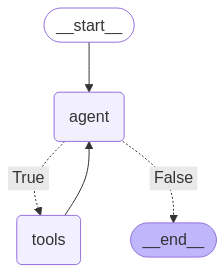

In [71]:
display(Image(graph.get_graph().draw_mermaid_png()))

# __

In [72]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [73]:
config = {"configurable": {"thread_id": "abc123"}}

In [74]:
messages = [HumanMessage(content="Er en Labrador Retriever en aktiv hund?")]
print_stream(graph.stream({"messages": messages}, stream_mode= "values"))

================================ Human Message =================================

Er en Labrador Retriever en aktiv hund?
[HumanMessage(content='Er en Labrador Retriever en aktiv hund?', additional_kwargs={}, response_metadata={}, id='bf72f257-028b-4fc9-8b4d-68bfe8ec5bc2')]
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_etk5o8imOAoVLLemsvJaFqa4)
 Call ID: call_etk5o8imOAoVLLemsvJaFqa4
  Args:
    query: Er en Labrador Retriever en aktiv hund
================================= Tool Message =================================
Name: search_tool

{'query': 'Er en Labrador Retriever en aktiv hund', 'search_content': 'Oprindelsesland: England\nLevealder: 12-14 år\nHøjde: Hanner 56-57 cm, tæver 54-56 cm\nVægt: Hanner 30-40 kg, tæver 25-35 kg\nFarve: Sort, gul eller brun\nFCI-gruppe: 8 (apporterende jagthunde)\nLabradorens baggrund\nLabradorens oprindelse er behæftet med en vis usikkerhed, men overordnet er der enighed om, at den s

In [12]:
input_message = "Kræver en labrador retriever meget pelspleje?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Kræver en labrador retriever meget pelspleje?
---CALL AGENT---
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_urIH5wDJZPYa7pFLVzx16AqA)
 Call ID: call_urIH5wDJZPYa7pFLVzx16AqA
  Args:
    query: Does a Labrador Retriever require a lot of grooming
================================= Tool Message =================================
Name: search_tool

{"query": "Does a Labrador Retriever require a lot of grooming", "search_content": "No content could be extracted from the page.", "source": {"url": "https://www.reddit.com/r/doggrooming/comments/to7o2b/how_often_should_i_have_my_lab_groomed/", "title": "How often should I have my lab groomed? : r/doggrooming - Reddit", "snippet": "Labs don't need trimming. Check the nails at least once a month and then bath when they get stinky, are shedding a lot from weather change, or ..."}}
---GENERATE NODE---
=